# 1. Logistic regression

For this exercise we will use student exam data to predict university admissions. The dataset consists of two exam scores for each student, and whether or not that student was admitted to the university.

In [16]:
%matplotlib inline
%xmode plain

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data1 = pd.read_csv('ex2data1.txt', header=None, names=['Exam 1', 'Exam 2', 'Decision'])
display(data1.info())
data1.head()

Exception reporting mode: Plain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Exam 1      100 non-null float64
Exam 2      100 non-null float64
Decision    100 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


None

,Exam 1,Exam 2,Decision
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## 1.1 Visualizing the data

A scatter plot of the two independent variables indicates that there appears to be a decision boundary between the admitted and not admitted students.

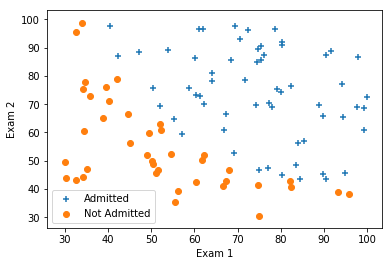

In [17]:
admitted = data1[data1['Decision'] == 1]
not_admitted = data1[data1['Decision'] == 0]

plt.scatter(admitted['Exam 1'], admitted['Exam 2'], marker='+', label='Admitted')
plt.scatter(not_admitted['Exam 1'], not_admitted['Exam 2'], label='Not Admitted')
plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.legend();

## 1.2 Implementation

### 1.2.1 Warmup exercise: sigmoid function

In this part of the exercise we implement the sigmoid function: $g(z) = \frac{1}{1+e^{-z}}$

In [4]:
# I'll compare my implementation with scipy's
from scipy.special import expit

sigmoid = lambda z: 1 / (1 + np.exp(-z))

values = np.linspace(1, 10, 10)
    
pd.DataFrame({
    'Sigmoid': sigmoid(values),
    'Expit': expit(values)
})

,Expit,Sigmoid
0,0.731059,0.731059
1,0.880797,0.880797
2,0.952574,0.952574
3,0.982014,0.982014
4,0.993307,0.993307
5,0.997527,0.997527
6,0.999089,0.999089
7,0.999665,0.999665
8,0.999877,0.999877
9,0.999955,0.999955


### 1.2.2 Cost function and gradient

We start out by defining our features and targets.

In [126]:
m, n = data1[['Exam 1', 'Exam 2']].shape

data1['Bias'] = np.ones(m)
X = data1[['Bias', 'Exam 1', 'Exam 2']].values
y = data1['Decision'].values.reshape(m, 1)

initial_theta = np.zeros(n + 1).reshape(n + 1, 1)

y.shape

(100, 1)

This is the cost function for logistic regression:

$J(\theta) = \frac{1}{m} \sum\limits_{i=1}^{m}[-y^{(i)} \log(h_{\theta}(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)}))]$

This is the gradient for the cost function:

$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m} \sum\limits_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)}) x_{j}^{(i)}$

In [127]:
from numpy import log

def cost_function(theta, X, y):
    J = (1 / m) * (
        -y * log(sigmoid(X @ theta)) - 
        (1 - y) * log((1 - sigmoid(X @ theta)))
    ).sum()

    grad = (1 / m) * ((sigmoid(X @ theta) - y) * X).sum(axis=0)
    return J, grad

J, grad = cost_function(initial_theta, X, y)
print('Cost at initial theta: {:.3f}'.format(J))
grad

Cost at initial theta: 0.693


array([ -0.1       , -12.00921659, -11.26284221])

In [8]:
test_theta = np.array([-24, 0.2, 0.2]).reshape(n + 1, 1)
J, grad = cost_function(test_theta, X, y)
print('Cost at test theta: {:.3f}'.format(J))
grad

Cost at test theta: 0.218


array([ 0.04290299,  2.56623412,  2.64679737])

### 1.2.3 Learning parameters using `minimize`

Rather than implement gradient descent by hand as in the last exercise, we will use a more advanced optimization algorithm from the `scipy.optimize` package.

In [11]:
from scipy.optimize import minimize

# Theta needs to be reshaped because minimize passes in a 1D array and cost_function expects a column vector
# jac=True means that cost_function also returns the Jacobian matrix (gradient)
res = minimize(lambda theta: cost_function(theta.reshape(n + 1, 1), X, y), initial_theta, jac=True)
# Note that despite the scary divide-by-zero warning, the optimizer succeeds

print("Cost at theta found by minimize: {:.3f}".format(res.fun))
res.x

Cost at theta found by minimize: 0.203


C:\Users\jack_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\jack_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


array([-25.16133284,   0.2062317 ,   0.2014716 ])

### 1.2.4 Evaluating logistic regression

Plotting the decision boundary found by logistic regression against the original data gives us some intuition for how well the algorithm is doing at distinguishing between students who were admitted and students who weren't.

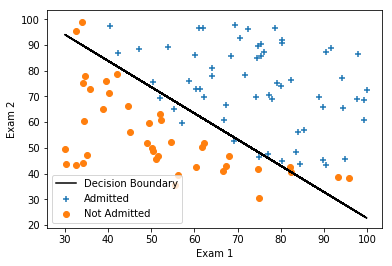

In [19]:
theta = res.x

x = X[:, 1]
boundary = lambda x: (theta[0] + theta[1] * x) /  - theta[2]

plt.scatter(admitted['Exam 1'], admitted['Exam 2'], marker='+', label='Admitted')
plt.scatter(not_admitted['Exam 1'], not_admitted['Exam 2'], label='Not Admitted')
plt.plot(x, boundary(x), color='black', label='Decision Boundary')
plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.legend();

Determine the probability that a particular test example is admitted.

In [15]:
p = sigmoid(np.array([1, 45, 85]) @ theta)
print("Probability is {:.3f}".format(p))

Probability is 0.776


To convert the probability to a prediction, we use a threshold of 0.5. The predictions made using this threshold ahve an accuracy of 89%.

In [14]:
def predict(theta, X):
    return sigmoid(X @ theta) > 0.5

prediction = predict(theta, X)
ground_truth = (y == True).flatten()
np.sum(prediction == ground_truth)

89

# 2. Regularized logistic regression

For this part of the exercise we will use a dataset consisting of microchip performance on two QA tests, with a target of whether or not a given microchip should be accepted for distribution.

In [20]:
data2 = pd.read_csv('ex2data2.txt', header=None, names=['Test 1', 'Test 2', 'Accepted'])
display(data2.info())
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
Test 1      118 non-null float64
Test 2      118 non-null float64
Accepted    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


None

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


## 2.1 Visualizing the data

This time the scatter plot reveals a non-linear decision boundary.

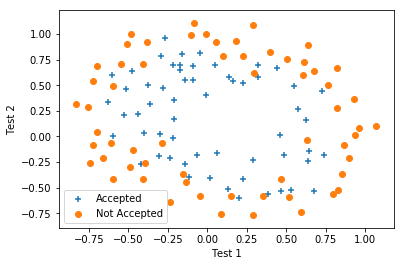

In [21]:
accepted = data2[data2['Accepted'] == 1]
not_accepted = data2[data2['Accepted'] == 0]

plt.scatter(accepted['Test 1'], accepted['Test 2'], marker='+', label='Accepted')
plt.scatter(not_accepted['Test 1'], not_accepted['Test 2'], label='Not Accepted')
plt.xlabel('Test 1')
plt.ylabel('Test 2')
plt.legend();

## 2.2 Feature mapping

In order to model the non-linear decision boundary, we will create new features for all terms in the sixth-order polynomial based on our two initial features.

In [131]:
order = 6
exponents = []
for i in range(0, order + 1):
    for j in range(0, order + 1):
        if i + j <= order:
            exponents.append((i, j))

X = np.ones((len(data2), len(terms)))
for i, row in data2.iterrows():
    for j, exponent in enumerate(exponents):
        X[i, j] = row['Test 1'] ** exponent[0] * row['Test 2'] ** exponent[1]

m, n = X.shape
y = data2['Accepted'].values.reshape(m, 1)

Note that there is also a class in scikit-learn to handle this.

In [130]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(6)
t = poly.fit_transform(data2[['Test 1', 'Test 2']])
t.shape

(118, 28)

## 2.3 Cost function and gradient

In order to prevent overfitting, we add a regularization term which penalizes the cost function for large parameter values:

$J(\theta) = \frac{1}{m} \sum\limits_{i=1}^{m}[-y^{(i)} \log(h_{\theta}(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)}))] + \frac{\lambda}{2 m} \sum\limits_{j=1}^{n} \theta_{j}^{2}$

For $j = 0$ the gradient is unchanged, but for $j > 0$ the gradient becomes:

$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m} \sum\limits_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)}) x_{j}^{(i)} + \frac{\lambda}{m} \theta_{j}$



In [141]:
def cost_function_reg(theta, X, y, _lambda):
    J = (1 / m) * (
        -y * log(sigmoid(X @ theta)) - 
        (1 - y) * log((1 - sigmoid(X @ theta)))
    ).sum() + (_lambda / (2 * m)) * (theta ** 2).sum()

    grad = (1 / m) * ((sigmoid(X @ theta) - y) * X).sum(axis=0).reshape(n, 1) + \
           (_lambda / m) * theta
    grad[0] = ((1 / m) * ((sigmoid(X @ theta) - y) * X).sum(axis=0))[0]
    return J, grad.flatten() # minimize complains if grad is a column vector

_lambda = 1
initial_theta = np.zeros(n).reshape(n, 1)
J, grad = cost_function_reg(initial_theta, t, y, _lambda)
print('Cost at initial theta: {:.3f}'.format(J))
grad[0:5]

Cost at initial theta: 0.693


array([  8.47457627e-03,   1.87880932e-02,   7.77711864e-05,
         5.03446395e-02,   1.15013308e-02])

### 2.3.1 Learning parameters using `minimize`

In [142]:
res = minimize(lambda theta: cost_function_reg(theta.reshape(n, 1), t, y, _lambda), np.zeros(n), jac=True)

print("Cost at theta found by minimize: {:.3f}".format(res.fun))
res.x[0:5]

Cost at theta found by minimize: 0.536


array([ 1.22936289,  0.63244485,  1.19453878, -1.974858  , -0.91081349])

## 2.4 Plotting the decision boundary

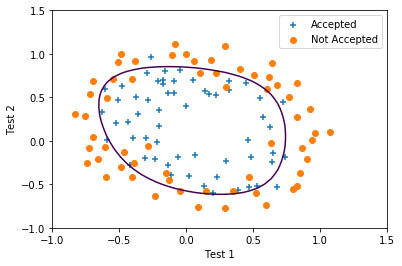

In [143]:
def plot_decision_boundary(res):
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros(len(u) * len(v)).reshape(len(u), len(v))

    theta = res.x

    for i in range(len(u)):
        for j in range(len(v)):
            z[i, j] = poly.fit_transform(np.array([[u[i], v[j]]])) @ theta

    plt.scatter(accepted['Test 1'], accepted['Test 2'], marker='+', label='Accepted')
    plt.scatter(not_accepted['Test 1'], not_accepted['Test 2'], label='Not Accepted')
    plt.contour(u, v, z.T, 0);
    plt.xlabel('Test 1')
    plt.ylabel('Test 2')
    plt.legend();
    
plot_decision_boundary(res)

## 2.5 Optional exercises

First let's see what the decision boundary without regularization looks like (overfitting).

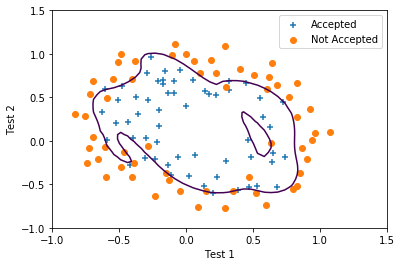

In [144]:
_lambda = 0
res = minimize(lambda theta: cost_function_reg(theta.reshape(n, 1), t, y, _lambda), np.zeros(n), jac=True)
plot_decision_boundary(res)

And now with too much regularization (underfitting).

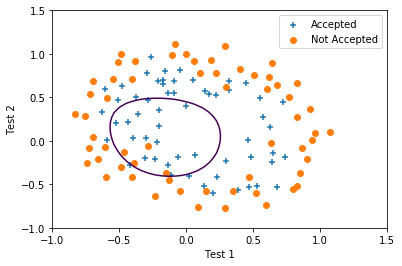

In [145]:
_lambda = 100
res = minimize(lambda theta: cost_function_reg(theta.reshape(n, 1), t, y, _lambda), np.zeros(n), jac=True)
plot_decision_boundary(res)